In [1]:
import sys

# 현재 노트북 커널의 Python 경로 확인
print(sys.executable)

# shap 완전 제거
!{sys.executable} -m pip uninstall -y shap

# 호환 버전 설치
!{sys.executable} -m pip install shap==0.41.0


C:\Users\Admin\anaconda3\envs\4vector\python.exe


  Using cached numba-0.63.1-cp310-cp310-win_amd64.whl.metadata (2.8 kB)
  Using cached cloudpickle-3.1.2-py3-none-any.whl.metadata (7.1 kB)
  Using cached llvmlite-0.46.0-cp310-cp310-win_amd64.whl.metadata (4.9 kB)
Using cached cloudpickle-3.1.2-py3-none-any.whl (22 kB)
Using cached numba-0.63.1-cp310-cp310-win_amd64.whl (2.7 MB)
Using cached llvmlite-0.46.0-cp310-cp310-win_amd64.whl (38.1 MB)

   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   ------------------------ --------------- 3/5 [numba]
   ------------------------ --------------- 3/5 [numba]
   ------------------------ --------------- 3/5 [numba]
   ------------------------ --------------- 3/5 [numba]
   ------------------------ --------------- 3/5 [numba]
   ------------------------ --------------- 3/5 [numba]
   ------------------------ --------------- 3/5 [numba]
   ------------------------ -----

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Windows 한글 폰트
mpl.rcParams["font.family"] = "Malgun Gothic"
mpl.rcParams["axes.unicode_minus"] = False


In [3]:
import pandas as pd
import numpy as np
import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from lightgbm import LGBMRegressor


In [4]:
csv_path = "new_flight_weather_merged.csv"
df = pd.read_csv(csv_path)

print("전체 데이터 수:", len(df))


Columns (28,49) have mixed types. Specify dtype option on import or set low_memory=False.


전체 데이터 수: 2843934


In [5]:
reg_df = df[df["상태"] == "지연"].copy()
print("상태=지연 데이터 수:", len(reg_df))

# 타겟 정제
reg_df = reg_df[reg_df["지연_분"].notna()]
reg_df = reg_df[reg_df["지연_분"] >= 0]

MAX_DELAY = 360
reg_df = reg_df[reg_df["지연_분"] <= MAX_DELAY]

print(reg_df["지연_분"].describe())


상태=지연 데이터 수: 481449
count    479872.000000
mean         56.778833
std          35.039417
min           0.000000
25%          36.000000
50%          46.000000
75%          64.000000
max         360.000000
Name: 지연_분, dtype: float64


In [6]:
num_cols = [
    "기온(°C)",
    "풍속_ms",
    "dep_hour",
    "dep_weekday",
    "is_weekend"
]

cat_cols = [
    "공항명",
    "출발지",
    "도착지",
    "flight_type"
]

num_cols = [c for c in num_cols if c in reg_df.columns]
cat_cols = [c for c in cat_cols if c in reg_df.columns]

X_cols = num_cols + cat_cols


In [7]:
reg_df["departure_datetime"] = pd.to_datetime(reg_df["departure_datetime"])
reg_df = reg_df.sort_values("departure_datetime")

split_date = reg_df["departure_datetime"].quantile(0.8)

train_df = reg_df[reg_df["departure_datetime"] <= split_date]
test_df  = reg_df[reg_df["departure_datetime"] > split_date]

X_train = train_df[X_cols]
y_train = train_df["지연_분"]

X_test  = test_df[X_cols]
y_test  = test_df["지연_분"]

print("Train:", len(X_train), "Test:", len(X_test))


Train: 383897 Test: 95975


In [8]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="UNKNOWN")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])


In [9]:
lgbm_reg = Pipeline([
    ("prep", preprocessor),
    ("reg", LGBMRegressor(
        objective="regression",
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

lgbm_reg.fit(X_train, y_train_log)

y_pred_log = lgbm_reg.predict(X_test)
y_pred = np.expm1(y_pred_log)

print("🌳 LightGBM (log target)")
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 383897, number of used features: 223
[LightGBM] [Info] Start training from score 3.945879
🌳 LightGBM (log target)
MAE : 18.146819981154025
RMSE: 28.85824702646577


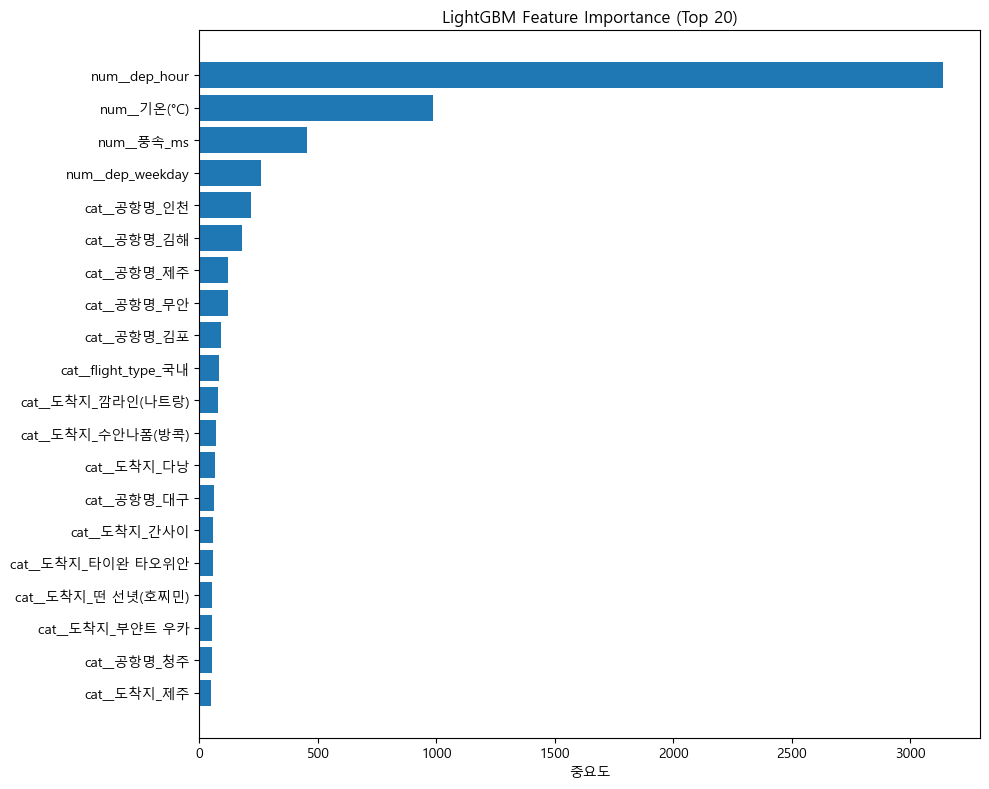

In [10]:
lgbm_model = lgbm_reg.named_steps["reg"]
feature_names = lgbm_reg.named_steps["prep"].get_feature_names_out()

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": lgbm_model.feature_importances_
}).sort_values("importance", ascending=False)

top_df = importance_df.head(20).iloc[::-1]

plt.figure(figsize=(10, 8))
plt.barh(top_df["feature"], top_df["importance"])
plt.title("LightGBM Feature Importance (Top 20)")
plt.xlabel("중요도")
plt.tight_layout()
plt.show()


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


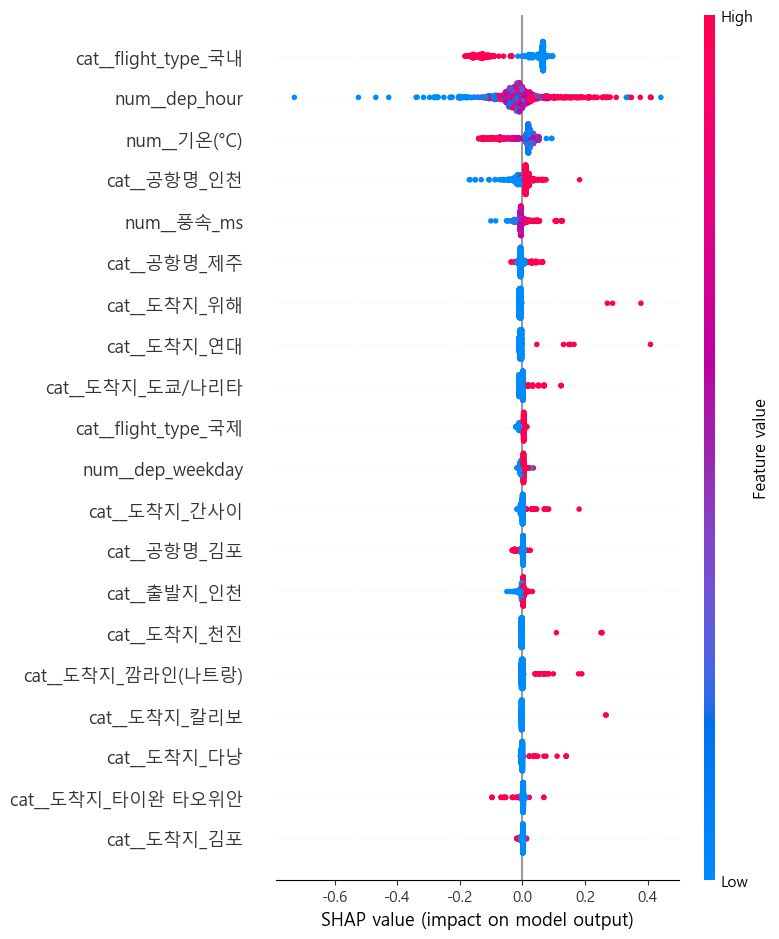

In [11]:
# ===============================
# SHAP (최종 안정 버전)
# ===============================

SHAP_SAMPLE = 1000  # 반드시 정의

# 전처리된 데이터 (dense로 바로 변환)
X_test_dense = lgbm_reg.named_steps["prep"].transform(
    X_test.iloc[:SHAP_SAMPLE]
).toarray()

# ✅ 최신 SHAP 권장 방식
explainer = shap.Explainer(
    lgbm_reg.named_steps["reg"],
    X_test_dense
)

shap_values = explainer(X_test_dense)

# Summary plot
shap.summary_plot(
    shap_values.values,
    X_test_dense,
    feature_names=feature_names,
    max_display=20
)


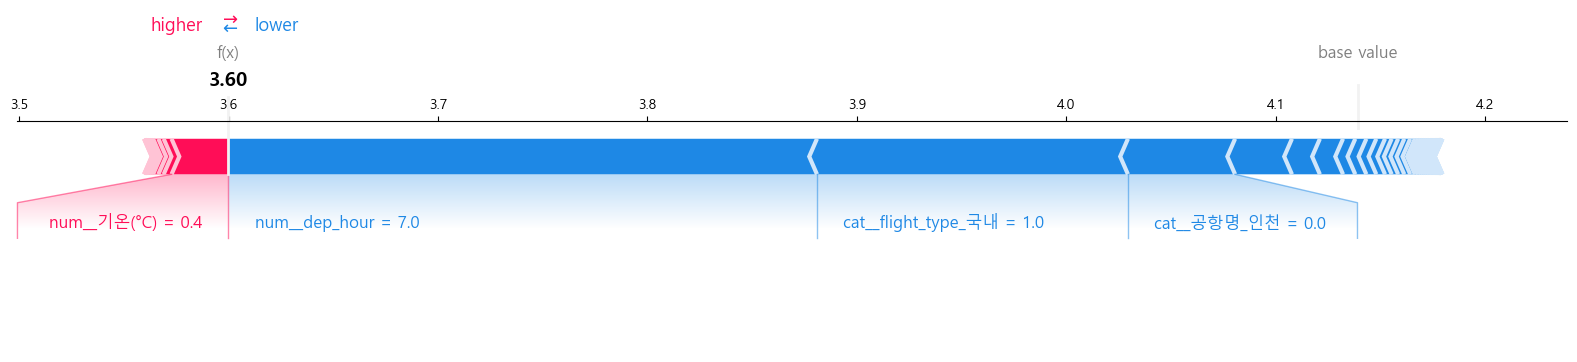

In [12]:
i = 10

shap.force_plot(
    explainer.expected_value,
    shap_values.values[i],
    X_test_dense[i],
    feature_names=feature_names,
    matplotlib=True
)


In [13]:
result_df = pd.DataFrame({
    "actual_delay": y_test.values[:SHAP_SAMPLE],
    "predicted_delay": y_pred[:SHAP_SAMPLE]
})

result_df.head(20)


,actual_delay,predicted_delay
0,37.0,46.665867
1,56.0,85.362395
2,40.0,48.108481
3,38.0,48.108481
4,9.0,34.662479
5,37.0,52.607479
6,70.0,52.607479
7,30.0,36.952680
8,146.0,79.523506
9,73.0,56.551510


## ✅ (추가) PPT용 시각화: 성능표 & 그래프

아래 셀은 **기존 코드는 유지**하고, **시각화용 표/그래프만** 생성합니다.

In [14]:
# ===============================
# ✅ 한글 폰트 깨짐 방지 설정
# ===============================
import matplotlib.pyplot as plt
import platform
import matplotlib.font_manager as fm

system = platform.system()

if system == "Windows":
    # Windows (대부분 Malgun Gothic 사용)
    plt.rcParams["font.family"] = "Malgun Gothic"

elif system == "Darwin":
    # macOS
    plt.rcParams["font.family"] = "AppleGothic"

else:
    # Linux (Colab / 서버)
    # 나눔고딕이 없을 경우 대비
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        plt.rcParams["font.family"] = "DejaVu Sans"

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

print(f"✅ 한글 폰트 설정 완료 ({system})")


✅ 한글 폰트 설정 완료 (Windows)


✅ [PPT용] 모델 성능 요약표 (MAE / RMSE) - MAE 기준 정렬


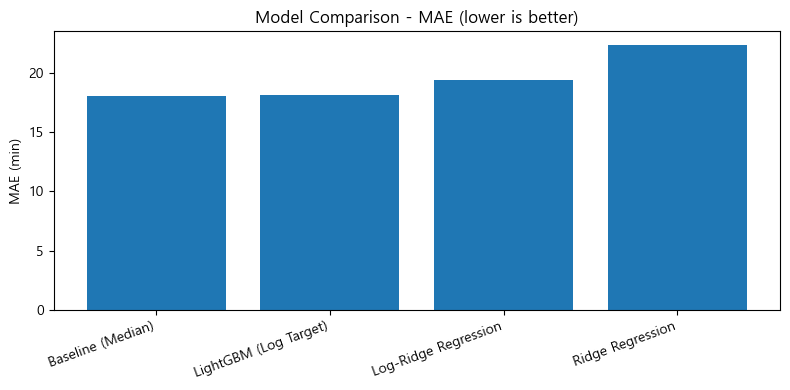

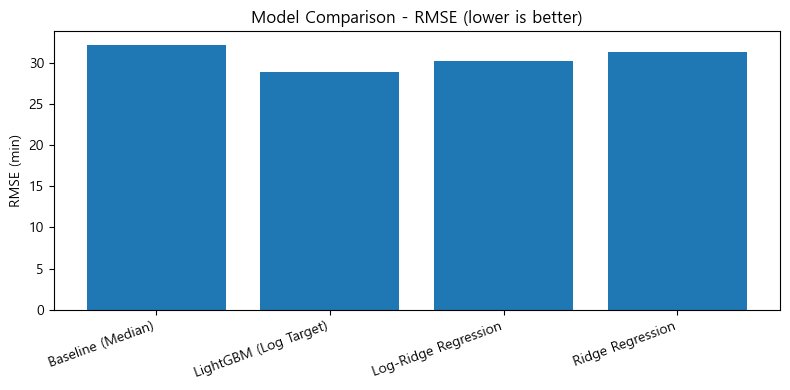

🏆 Best model by MAE: Baseline (Median)


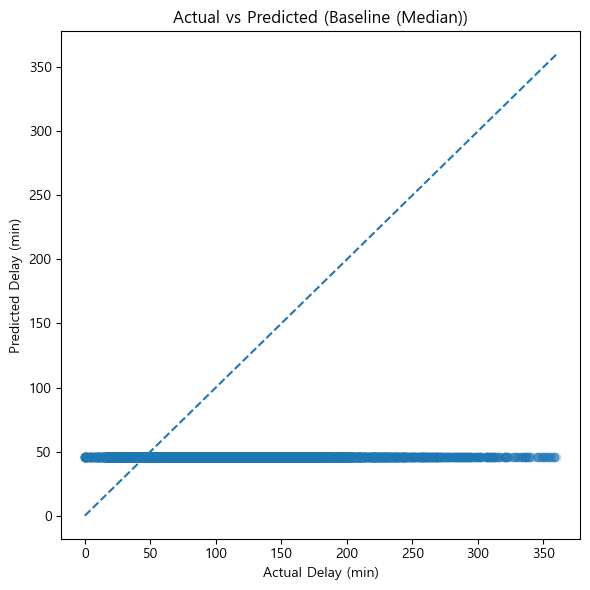

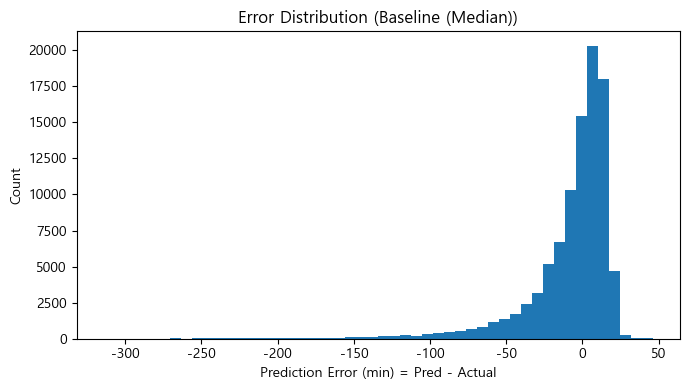

✅ [PPT용] 지연 구간별 MAE


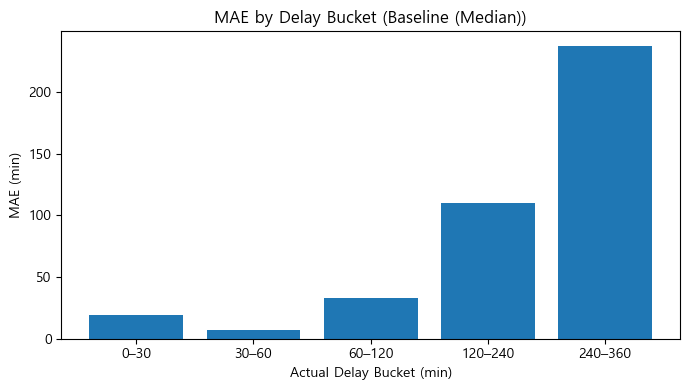

✅ 예측 샘플 (상위 10개)


,Actual Delay (min),Predicted Delay (min),Error (min)
0,37.0,46.0,9.0
1,56.0,46.0,-10.0
2,40.0,46.0,6.0
3,38.0,46.0,8.0
4,9.0,46.0,37.0
5,37.0,46.0,9.0
6,70.0,46.0,-24.0
7,30.0,46.0,16.0
8,146.0,46.0,-100.0
9,73.0,46.0,-27.0


In [15]:
# =====================================================
# 📌 (추가) PPT용 시각화 표 & 그래프 자동 생성 파트
# =====================================================
# ✅ 요구사항
# - 기존 코드(위쪽)는 절대 수정하지 않고 그대로 유지
# - 맨 아래에 "PPT에 바로 넣을 수 있는" 표/그래프를 생성하는 코드만 추가
#
# ✅ 이 셀에서 만드는 것
# 1) 모델 성능 비교 요약표 (MAE / RMSE)
# 2) 모델별 MAE / RMSE 막대그래프 (PPT용)
# 3) (베스트 모델 기준) 실제 vs 예측 산점도
# 4) (베스트 모델 기준) 오차 분포 히스토그램
# 5) (베스트 모델 기준) 지연 구간별 MAE (0-30/30-60/...)
# 6) 예측 샘플 테이블(부록/Appendix용)
# =====================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------------------------------
# 0) 필수 변수 존재 여부 체크
# -----------------------------------------------------
# 아래 변수들은 "위쪽 기존 코드"에서 만들어졌어야 함.
# 만약 에러가 나면, 위쪽 코드 실행 순서를 확인하면 됨.
required_vars = ["X_test", "y_test"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(f"❌ 필수 변수가 없습니다: {missing}  -> 위쪽 셀들을 먼저 실행하세요.")

# -----------------------------------------------------
# 1) 예측값(prediction) 수집: 가능한 모델만 자동으로 모아서 비교
# -----------------------------------------------------
# 이 노트북마다 존재하는 모델이 다를 수 있음 (예: 한 파일은 LightGBM만, 다른 파일은 Ridge까지 있음)
# 그래서 '존재하는 모델만' 자동으로 모으는 방식으로 짰음.
preds = {}

# (1) Baseline: "중앙값 예측" (아무 모델도 안 써도 되는 비교 기준)
# - 학습 데이터(y_train)가 있으면 train 중앙값을 사용
# - 없으면 test 중앙값을 사용 (노트북 구조에 따라 y_train이 없을 수 있으니까 안전장치)
if "y_train" in globals():
    baseline_value = float(np.nanmedian(y_train))
else:
    baseline_value = float(np.nanmedian(y_test))
preds["Baseline (Median)"] = np.full(shape=len(y_test), fill_value=baseline_value)

# (2) Linear Regression (있으면 포함)
if "lin_reg" in globals():
    try:
        preds["Linear Regression"] = lin_reg.predict(X_test)
    except Exception as e:
        print("⚠️ Linear Regression 예측 실패:", repr(e))

# (3) Ridge / Log-Ridge (있으면 포함)
# ⚠️ 주의: 위쪽 코드에서 ridge_reg가 'log 타겟으로 재학습'되어 있을 수 있음.
# 그래서 여기서는 기존 ridge_reg를 덮어쓰지 않도록,
# "새로운 변수(ridge_raw_reg / ridge_log_reg)"로 다시 만들어서 사용함.
if all(v in globals() for v in ["preprocessor", "X_train", "y_train"]):
    try:
        from sklearn.pipeline import Pipeline
        from sklearn.linear_model import Ridge

        # 3-1) Ridge (Raw Target)
        ridge_raw_reg = Pipeline([
            ("prep", preprocessor),
            ("reg", Ridge(alpha=1.0))
        ])
        ridge_raw_reg.fit(X_train, y_train)
        preds["Ridge Regression"] = ridge_raw_reg.predict(X_test)

        # 3-2) Log-Ridge (Log Target → expm1 역변환)
        ridge_log_reg = Pipeline([
            ("prep", preprocessor),
            ("reg", Ridge(alpha=1.0))
        ])
        ridge_log_reg.fit(X_train, np.log1p(y_train))
        preds["Log-Ridge Regression"] = np.expm1(ridge_log_reg.predict(X_test))

    except Exception as e:
        print("⚠️ Ridge / Log-Ridge 재학습 또는 예측 실패:", repr(e))

# (4) LightGBM (있으면 포함)
# - 노트북에 lgbm_reg 파이프라인이 존재하면 자동 포함
# - '로그 타겟인지'는 예측값 범위로 휴리스틱 판단
if "lgbm_reg" in globals():
    try:
        raw_pred = lgbm_reg.predict(X_test)

        # ✅ 휴리스틱: 예측값 95% 지점이 20 이하라면 (대부분 log 스케일일 확률 높음)
        # - log1p(360) ≈ 5.89 이므로 보통 0~10 사이에 몰림
        # - raw target이면 예측값이 분 단위로 0~360 근처까지 나오는 경우가 많음
        if np.nanpercentile(raw_pred, 95) <= 20:
            preds["LightGBM (Log Target)"] = np.expm1(raw_pred)
        else:
            preds["LightGBM (Raw Target)"] = raw_pred

    except Exception as e:
        print("⚠️ LightGBM 예측 실패:", repr(e))

# -----------------------------------------------------
# 2) 성능 요약표 생성 (PPT 핵심 표)
# -----------------------------------------------------
# - MAE: 평균적으로 몇 분 틀리는지
# - RMSE: 큰 지연에서 오차가 얼마나 커지는지(큰 오차에 더 민감)
rows = []
for model_name, y_hat in preds.items():
    rows.append({
        "모델": model_name,
        "MAE (분)": mean_absolute_error(y_test, y_hat),
        "RMSE (분)": np.sqrt(mean_squared_error(y_test, y_hat))
    })

summary_df = pd.DataFrame(rows).sort_values("MAE (분)").reset_index(drop=True)

print("✅ [PPT용] 모델 성능 요약표 (MAE / RMSE) - MAE 기준 정렬")
summary_df

# -----------------------------------------------------
# 3) 모델별 MAE / RMSE 막대그래프 (PPT 시각화)
# -----------------------------------------------------
# - PPT에서는 표 + 막대그래프를 같이 넣으면 설득력이 확 올라감
plt.figure(figsize=(8, 4))
plt.bar(summary_df["모델"], summary_df["MAE (분)"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("MAE (min)")
plt.title("Model Comparison - MAE (lower is better)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(summary_df["모델"], summary_df["RMSE (분)"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("RMSE (min)")
plt.title("Model Comparison - RMSE (lower is better)")
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 4) 베스트 모델 선정 (MAE가 가장 낮은 모델)
# -----------------------------------------------------
best_model_name = summary_df.loc[0, "모델"]
best_pred = preds[best_model_name]

print(f"🏆 Best model by MAE: {best_model_name}")

# -----------------------------------------------------
# 5) 실제값 vs 예측값 산점도 (베스트 모델 기준)
# -----------------------------------------------------
# - 점들이 대각선(y=x) 주변에 몰릴수록 예측이 정확
plt.figure(figsize=(6, 6))
plt.scatter(y_test, best_pred, alpha=0.2)

max_val = max(float(np.nanmax(y_test)), float(np.nanmax(best_pred)))
plt.plot([0, max_val], [0, max_val], linestyle="--")

plt.xlabel("Actual Delay (min)")
plt.ylabel("Predicted Delay (min)")
plt.title(f"Actual vs Predicted ({best_model_name})")
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 6) 오차 분포 히스토그램 (베스트 모델 기준)
# -----------------------------------------------------
# - 오차가 0 근처에 몰릴수록 좋음
# - 오른쪽 꼬리가 길면(+) '과대예측', 왼쪽 꼬리가 길면(-) '과소예측' 경향
errors = best_pred - y_test

plt.figure(figsize=(7, 4))
plt.hist(errors, bins=50)
plt.xlabel("Prediction Error (min) = Pred - Actual")
plt.ylabel("Count")
plt.title(f"Error Distribution ({best_model_name})")
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 7) 지연 구간별 MAE (베스트 모델 기준)
# -----------------------------------------------------
# - 지연이 길어질수록 예측이 어려워지는데,
#   그 난이도 증가가 어느 정도인지 구간별로 확인 가능
bins = [0, 30, 60, 120, 240, 360]
labels = ["0–30", "30–60", "60–120", "120–240", "240–360"]

bucket_df = pd.DataFrame({
    "actual_delay": y_test.values,
    "pred_delay": best_pred
})

bucket_df["delay_bucket"] = pd.cut(
    bucket_df["actual_delay"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

bucket_mae = bucket_df.groupby("delay_bucket").apply(
    lambda x: mean_absolute_error(x["actual_delay"], x["pred_delay"])
).reset_index(name="MAE")

print("✅ [PPT용] 지연 구간별 MAE")
bucket_mae

plt.figure(figsize=(7, 4))
plt.bar(bucket_mae["delay_bucket"].astype(str), bucket_mae["MAE"])
plt.xlabel("Actual Delay Bucket (min)")
plt.ylabel("MAE (min)")
plt.title(f"MAE by Delay Bucket ({best_model_name})")
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 8) 예측 샘플 테이블 (부록/Appendix용)
# -----------------------------------------------------
# - PPT 마지막 장에 “실제 예측 사례”로 넣기 좋음
sample_result_df = pd.DataFrame({
    "Actual Delay (min)": y_test.values,
    "Predicted Delay (min)": best_pred,
    "Error (min)": best_pred - y_test.values
})

print("✅ 예측 샘플 (상위 10개)")
sample_result_df.head(10)
